### Import required libraries

In [52]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import silhouette_score
from collections import Counter

## Data Collection

Data that is used in this project was collected from TMDB website using its API. The data has been filtered by minimum average rating (5.0) and minimum votes (500) to maintain size of the data. First we called an API to collect id of each movie that is match the criteria. Then we used the id to get detail information of each movie using another API. We also collected the review data for each movie. All data that has been collected was save into csv files. 

#### Collecting Movies id so that we can use it to call API for getting details of movies

In [ ]:
''' Has been ran successfully
import requests
import pandas as pd
import time

API_KEY = "30c8ea0596717c63a88684285f5afe15"

def fetch_movies_page(min_rating=0.0,
                      min_votes=0,
                      page=1,
                      language="en-US"):
    """
    Fetch one page of movies from TMDB /discover/movie with rating filters.
    Returns parsed JSON.
    """
    url = "https://api.themoviedb.org/3/discover/movie"

    params = {
        "api_key": API_KEY,
        "language": language, 
        "rating.gte": min_rating, # min rating filter
        "vote_count.gte": min_votes,    # only well-voted movies
        "page": page
    }

    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()

def collect_movies(min_rating=0.0,
                   min_votes=0,
                   max_pages=1):
    """
    Loop through pages of /discover/movie,
    map genre_ids -> genre names,
    return list of dict rows.
    """
    all_movies = []

    for p in range(1, max_pages + 1):
        data = fetch_movies_page(
            min_rating=min_rating,
            min_votes=min_votes,
            page=p
        )

        results = data.get("results", [])
        if not results:
            break

        for m in results:
            movie_row = {
                "id": m.get("id"),
                "title": m.get("title"),
            }
            all_movies.append(movie_row)

        time.sleep(0.25)

        # stop if we've reached the actual last page
        total_pages = data.get("total_pages", max_pages)
        if p >= total_pages:
            break

    df = pd.DataFrame(all_movies)
    return df

if __name__ == "__main__":
    # Example usage:
    df_movies = collect_movies(
        min_rating=5.0,    # rating >= 8.0
        min_votes=500,    # with at least 1000 votes
        max_pages=370       # pull first 5 pages (~100 movies)
    )
    
    # Save to CSV
    df_movies.to_csv("movie_ids.csv", index=False, encoding="utf-8")
'''

' Has been ran successfully\nimport requests\nimport pandas as pd\nimport time\n\nAPI_KEY = "30c8ea0596717c63a88684285f5afe15"\n\ndef fetch_movies_page(min_rating=0.0,\n                      min_votes=0,\n                      page=1,\n                      language="en-US"):\n    """\n    Fetch one page of movies from TMDB /discover/movie with rating filters.\n    Returns parsed JSON.\n    """\n    url = "https://api.themoviedb.org/3/discover/movie"\n\n    params = {\n        "api_key": API_KEY,\n        "language": language, \n        "vote_average.gte": min_rating, # min rating filter\n        "vote_count.gte": min_votes,    # only well-voted movies\n        "page": page\n    }\n\n    r = requests.get(url, params=params)\n    r.raise_for_status()\n    return r.json()\n\ndef collect_movies(min_rating=0.0,\n                   min_votes=0,\n                   max_pages=1):\n    """\n    Loop through pages of /discover/movie,\n    map genre_ids -> genre names,\n    return list of dict r

#### Create functions to fetch detail information of a movie

In [54]:
''' Has been ran
def fetch_movie_data(movie_id, api_key=API_KEY):
    """
    Fetch detailed movie data from TMDB /movie/{movie_id}.
    Returns parsed JSON.
    """
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    params = {
        "api_key": api_key,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()

def collect_movie_details(movie_ids, language_map,api_key=API_KEY):
    """
    Given a list of movie IDs, fetch detailed data for each movie.
    Returns a DataFrame with detailed movie information.
    """
    all_movie_details = []
    i = 1
    for movie_id in movie_ids:
        print(i)
        i += 1
        data = fetch_movie_data(movie_id, api_key=api_key)
        details = {
            "id": data.get("id"),
            "imdb_id": data.get("imdb_id"),
            "title": data.get("title"),
            "original_title": data.get("original_title"),
            'genres': [g['name'] for g in data.get('genres', [])],
            "overview": data.get("overview"),
            "tagline": data.get("tagline"),
            "release_year": data.get("release_date").split("-")[0],
            "release_month": data.get("release_date").split("-")[1],
            "release_date": data.get("release_date").split("-")[2],
            "runtime": data.get("runtime"),
            "rating": data.get("vote_average"),
            "vote_count": data.get("vote_count"),
            "popularity": data.get("popularity"),
            "adult": data.get("adult"),
            "original_languages": map_language_code(language_map, data.get("original_language")),
            "production_countries": [c['name'] for c in data.get('production_countries', [])],
        }
        all_movie_details.append(details)
        time.sleep(0.3)  

    df_movies = pd.DataFrame(all_movie_details)
    return df_movies

def get_language_map():
    url = "https://api.themoviedb.org/3/configuration/languages"
    params = {
        "api_key": API_KEY,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    language_map = {}
    for lang in r.json():
        language_map[lang['iso_639_1']] = lang['english_name']
    return language_map

def map_language_code(language_map, lang_code):
    """
    Map ISO 639-1 language codes to full language names.
    """
    return language_map.get(lang_code, "Unknown")
'''

' Has been ran\ndef fetch_movie_data(movie_id, api_key=API_KEY):\n    """\n    Fetch detailed movie data from TMDB /movie/{movie_id}.\n    Returns parsed JSON.\n    """\n    url = f"https://api.themoviedb.org/3/movie/{movie_id}"\n    params = {\n        "api_key": api_key,\n    }\n    r = requests.get(url, params=params)\n    r.raise_for_status()\n    return r.json()\n\ndef collect_movie_details(movie_ids, language_map,api_key=API_KEY):\n    """\n    Given a list of movie IDs, fetch detailed data for each movie.\n    Returns a DataFrame with detailed movie information.\n    """\n    all_movie_details = []\n    i = 1\n    for movie_id in movie_ids:\n        print(i)\n        i += 1\n        data = fetch_movie_data(movie_id, api_key=api_key)\n        details = {\n            "id": data.get("id"),\n            "imdb_id": data.get("imdb_id"),\n            "title": data.get("title"),\n            "original_title": data.get("original_title"),\n            \'genres\': [g[\'name\'] for g in da

#### Collecting details of each movie and save them into a csv file for future use

In [55]:
''' Has been ran
data_ids = pd.read_csv("movie_ids.csv")
language_map = get_language_map()
data_details = collect_movie_details(data_ids['id'], language_map)
data_details.to_csv("detailed_movie_data.csv", index=False, encoding="utf-8")
'''

' Has been ran\ndata_ids = pd.read_csv("movie_ids.csv")\nlanguage_map = get_language_map()\ndata_details = collect_movie_details(data_ids[\'id\'], language_map)\ndata_details.to_csv("detailed_movie_data.csv", index=False, encoding="utf-8")\n'

#### Collect reviews data of each movie

In [56]:
'''
def fetch_review_data(movie_id, page=1, api_key=API_KEY):
    """
    Fetch detailed movie data from TMDB /movie/{movie_id}.
    Returns parsed JSON.
    """
    url = f"https://api.themoviedb.org/3/movie/{movie_id}/reviews"
    params = {
        "api_key": api_key,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()


def collect_review_details(movie_ids, api_key=API_KEY):
    """
    Given a list of movie IDs, fetch detailed data for each movie.
    Returns a DataFrame with detailed movie information.
    """
    all_review_details = []
    i = 1
    for movie_id in movie_ids:
        print(i)
        i += 1
        page = 1
        data = fetch_review_data(movie_id, api_key=api_key)
        total_pages = data.get("total_pages")
        total_results = data.get("total_results")
        if total_pages > 1:            
            for j in range(total_results - (total_pages-1)*20 if page == total_pages else 20):
                details = {
                    "movie_id": data.get("id"),
                    "username": data.get("results")[j].get("author_details").get("username"),
                    "rating": data.get("results")[j].get("author_details").get("rating"),
                    "review": data.get("results")[j].get("content"),
                }
                all_review_details.append(details)
                time.sleep(0.3)
            page = page + 1
            if page > total_pages:
                break
            data = fetch_review_data(movie_id, page, api_key=api_key)
        else:
            for j in range(total_results):
                details = {
                    "movie_id": data.get("id"),
                    "username": data.get("results")[j].get("author_details").get("username"),
                    "rating": data.get("results")[j].get("author_details").get("rating"),
                    "review": data.get("results")[j].get("content"),
                }
                all_review_details.append(details)
                time.sleep(0.3)

    df_movies = pd.DataFrame(all_review_details)
    return df_movies
'''

'\ndef fetch_review_data(movie_id, page=1, api_key=API_KEY):\n    """\n    Fetch detailed movie data from TMDB /movie/{movie_id}.\n    Returns parsed JSON.\n    """\n    url = f"https://api.themoviedb.org/3/movie/{movie_id}/reviews"\n    params = {\n        "api_key": api_key,\n    }\n    r = requests.get(url, params=params)\n    r.raise_for_status()\n    return r.json()\n\n\ndef collect_review_details(movie_ids, api_key=API_KEY):\n    """\n    Given a list of movie IDs, fetch detailed data for each movie.\n    Returns a DataFrame with detailed movie information.\n    """\n    all_review_details = []\n    i = 1\n    for movie_id in movie_ids:\n        print(i)\n        i += 1\n        page = 1\n        data = fetch_review_data(movie_id, api_key=api_key)\n        total_pages = data.get("total_pages")\n        total_results = data.get("total_results")\n        if total_pages > 1:            \n            for j in range(total_results - (total_pages-1)*20 if page == total_pages else 20):\n

#### Save them into a csv file

In [57]:
'''
data_ids = pd.read_csv("movie_ids.csv")
review_details = collect_review_details(data_ids['id'])
review_details.to_csv("detailed_review_data.csv", index=False, encoding="utf-8")
'''

'\ndata_ids = pd.read_csv("movie_ids.csv")\nreview_details = collect_review_details(data_ids[\'id\'])\nreview_details.to_csv("detailed_review_data.csv", index=False, encoding="utf-8")\n'

## Load saved data (csv file) into pandas dataframe

In [58]:
df_movies = pd.read_csv("movie_details_with_director_completed.csv")
# df_director = pd.read_csv("movies_data_director.csv")
df_reviews = pd.read_csv("detailed_review_data.csv")

In [59]:
'''
API_KEY = "30c8ea0596717c63a88684285f5afe15"
def get_directors(movie_id,api_key=API_KEY):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
    params = {
        "api_key": api_key,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    crew = data.get("crew", [])
    directors = [p["name"] for p in crew if p.get("job") == "Director"]
    # dataset.loc[dataset['id'] == movie_id, 'director'] = r.json()['crew'][0]['name']
    return directors
'''


'\nAPI_KEY = "30c8ea0596717c63a88684285f5afe15"\ndef get_directors(movie_id,api_key=API_KEY):\n    url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"\n    params = {\n        "api_key": api_key,\n    }\n    r = requests.get(url, params=params)\n    r.raise_for_status()\n    data = r.json()\n    crew = data.get("crew", [])\n    directors = [p["name"] for p in crew if p.get("job") == "Director"]\n    # dataset.loc[dataset[\'id\'] == movie_id, \'director\'] = r.json()[\'crew\'][0][\'name\']\n    return directors\n'

Print total movies is the data

In [60]:
print("Total movies:", len(df_movies))
df_movies.head()

Total movies: 7455


,id,imdb_id,title,original_title,genres,overview,tagline,release_year,release_month,release_date,runtime,rating,vote_count,popularity,adult,original_languages,production_countries,director
0,1038392,tt22898462,The Conjuring: Last Rites,The Conjuring: Last Rites,['Horror'],Paranormal investigators Ed and Lorraine Warre...,The case that ended it all.,2025,9,3,135,6.990,1152,181.8772,False,English,['United States of America'],Michael Chaves
1,7451,tt0295701,xXx,xXx,"['Action', 'Adventure', 'Thriller', 'Crime']",Xander Cage is your standard adrenaline junkie...,A new breed of secret agent.,2002,8,9,124,5.965,4605,144.5066,False,English,['United States of America'],Rob Cohen
2,1010581,tt21909764,My Fault,Culpa mía,"['Drama', 'Romance', 'Thriller']","Noah must leave her city, boyfriend, and frien...",Love can only survive in the shadow of secrets.,2023,6,8,117,7.768,3889,143.5740,False,Spanish,['Spain'],Domingo González
3,617126,tt10676052,The Fantastic 4: First Steps,The Fantastic 4: First Steps,"['Science Fiction', 'Adventure']",Against the vibrant backdrop of a 1960s-inspir...,Welcome to the family.,2025,7,23,115,7.107,2099,138.8317,False,English,['United States of America'],Matt Shakman
4,803796,tt14205554,KPop Demon Hunters,KPop Demon Hunters,"['Fantasy', 'Music', 'Comedy', 'Animation']","When K-pop superstars Rumi, Mira and Zoey aren...",They sing. They dance. They battle demons.,2025,6,20,96,8.232,1764,132.3623,False,English,['United States of America'],Chris Appelhans


Preview raw review data

In [61]:
df_reviews.head()

,movie_id,username,rating,review
0,1038392,axsih,NaN,I expected better. A disappointment.
1,1038392,Geronimo1967,6.0,"Oh well, all good things must come to an end -..."
2,7451,Geronimo1967,6.0,Vin Diesel is actually quite good in this as a...
3,1010581,Geronimo1967,5.0,Someone must have got fed up with the constant...
4,617126,msbreviews,7.0,FULL SPOILER-FREE REVIEW @ https://talkingfilm...


## Filter data that contains NaN or empty

In [62]:
df_movies.isnull().sum()    # Check for missing values
df_movies = df_movies.dropna(subset=["overview"]) # Drop rows where 'overview' is NaN

In [63]:
print(df_reviews.isnull().sum()) # Check for missing values
df_reviews = df_reviews.dropna(subset=["rating"]) # Drop rows where 'review' is NaN

movie_id       0
username       0
rating      1411
review         0
dtype: int64


Total data and users after filter

In [64]:
print("Total movies:", len(df_movies))
print("Total reviews:", len(df_reviews))
print("Total users:", len(df_reviews["username"].unique()))

Total movies: 7454
Total reviews: 14745
Total users: 1232


### Add release decade column to movie dataset

In [65]:
df_movies["release_decade"] = (df_movies["release_year"] // 10) * 10
df_movies.head()

,id,imdb_id,title,original_title,genres,overview,tagline,release_year,release_month,release_date,runtime,rating,vote_count,popularity,adult,original_languages,production_countries,director,release_decade
0,1038392,tt22898462,The Conjuring: Last Rites,The Conjuring: Last Rites,['Horror'],Paranormal investigators Ed and Lorraine Warre...,The case that ended it all.,2025,9,3,135,6.990,1152,181.8772,False,English,['United States of America'],Michael Chaves,2020
1,7451,tt0295701,xXx,xXx,"['Action', 'Adventure', 'Thriller', 'Crime']",Xander Cage is your standard adrenaline junkie...,A new breed of secret agent.,2002,8,9,124,5.965,4605,144.5066,False,English,['United States of America'],Rob Cohen,2000
2,1010581,tt21909764,My Fault,Culpa mía,"['Drama', 'Romance', 'Thriller']","Noah must leave her city, boyfriend, and frien...",Love can only survive in the shadow of secrets.,2023,6,8,117,7.768,3889,143.5740,False,Spanish,['Spain'],Domingo González,2020
3,617126,tt10676052,The Fantastic 4: First Steps,The Fantastic 4: First Steps,"['Science Fiction', 'Adventure']",Against the vibrant backdrop of a 1960s-inspir...,Welcome to the family.,2025,7,23,115,7.107,2099,138.8317,False,English,['United States of America'],Matt Shakman,2020
4,803796,tt14205554,KPop Demon Hunters,KPop Demon Hunters,"['Fantasy', 'Music', 'Comedy', 'Animation']","When K-pop superstars Rumi, Mira and Zoey aren...",They sing. They dance. They battle demons.,2025,6,20,96,8.232,1764,132.3623,False,English,['United States of America'],Chris Appelhans,2020


## Visualization of key features of the data

### Rating distribution

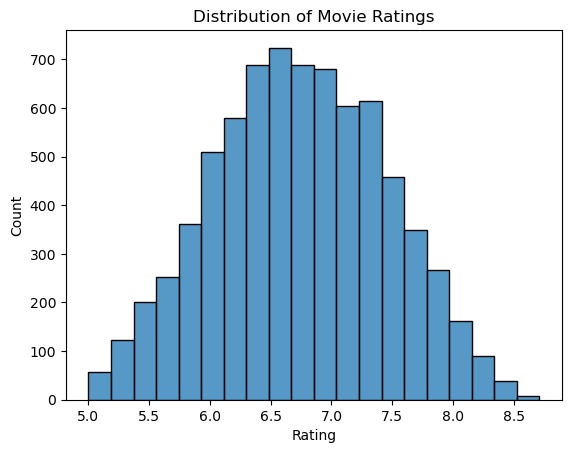

In [66]:
sns.histplot(df_movies["rating"], bins=20, kde=False)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### Runtime Distribution

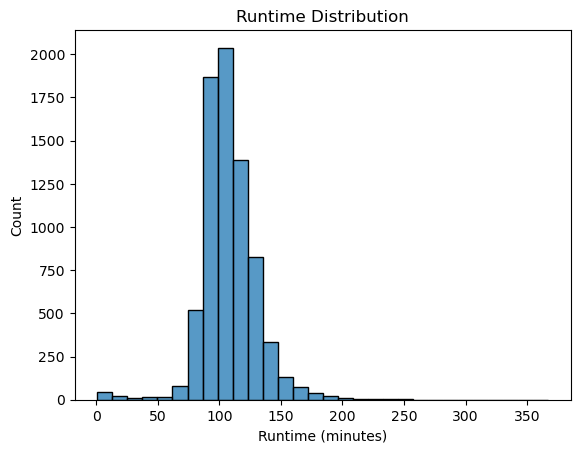

In [67]:
sns.histplot(df_movies["runtime"], bins=30, kde=False)
plt.title("Runtime Distribution")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Count")
plt.show()

### Popularity Distribution

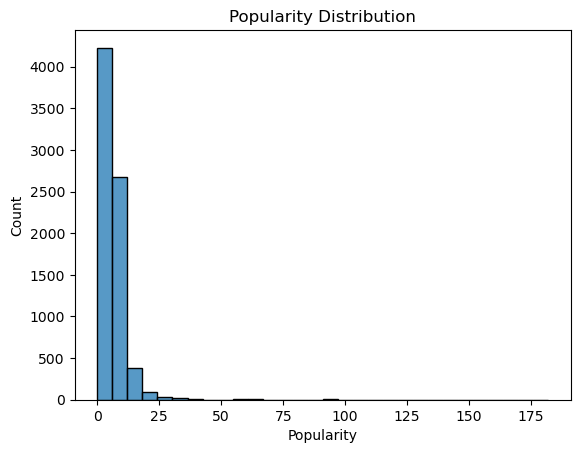

In [68]:
sns.histplot(df_movies["popularity"], bins=30, kde=False)
plt.title("Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

### Votecount Distribution

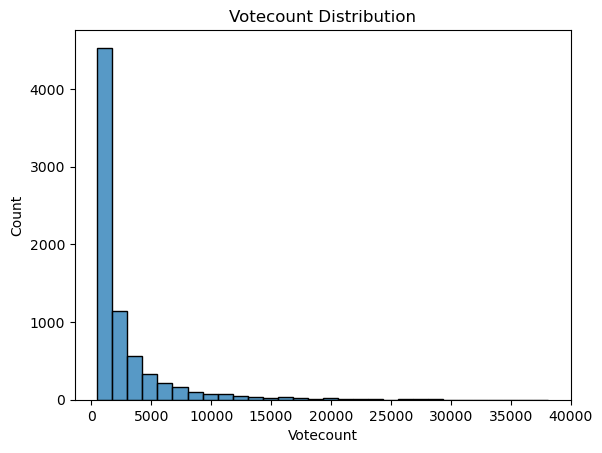

In [69]:
sns.histplot(df_movies["vote_count"], bins=30, kde=False)
plt.title("Votecount Distribution")
plt.xlabel("Votecount")
plt.ylabel("Count")
plt.show()

### Movies released per decade

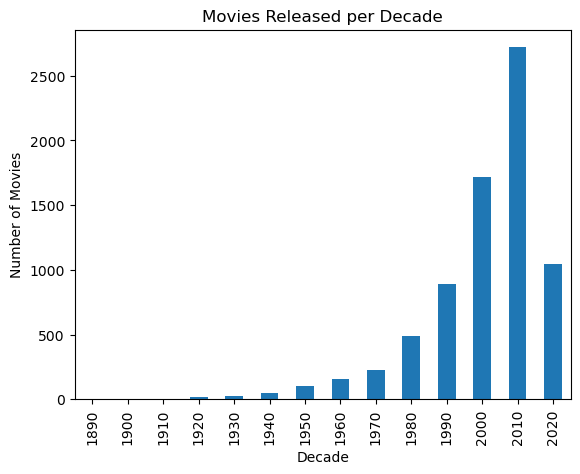

In [70]:
movies_per_decade = df_movies["release_decade"].value_counts().sort_index()
movies_per_decade.plot(kind='bar')
plt.title("Movies Released per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.show()


### Distribution of Genres

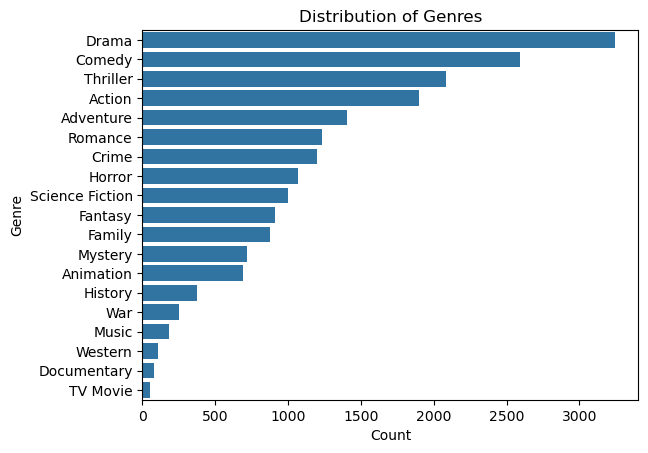

In [71]:
s = df_movies["genres"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
genre_counts = s.explode().value_counts()
genre_df = pd.DataFrame(list(genre_counts.items()), columns=["Genre", "Count"])
sns.barplot(x="Count", y="Genre", data=genre_df)
plt.title("Distribution of Genres")
plt.show()


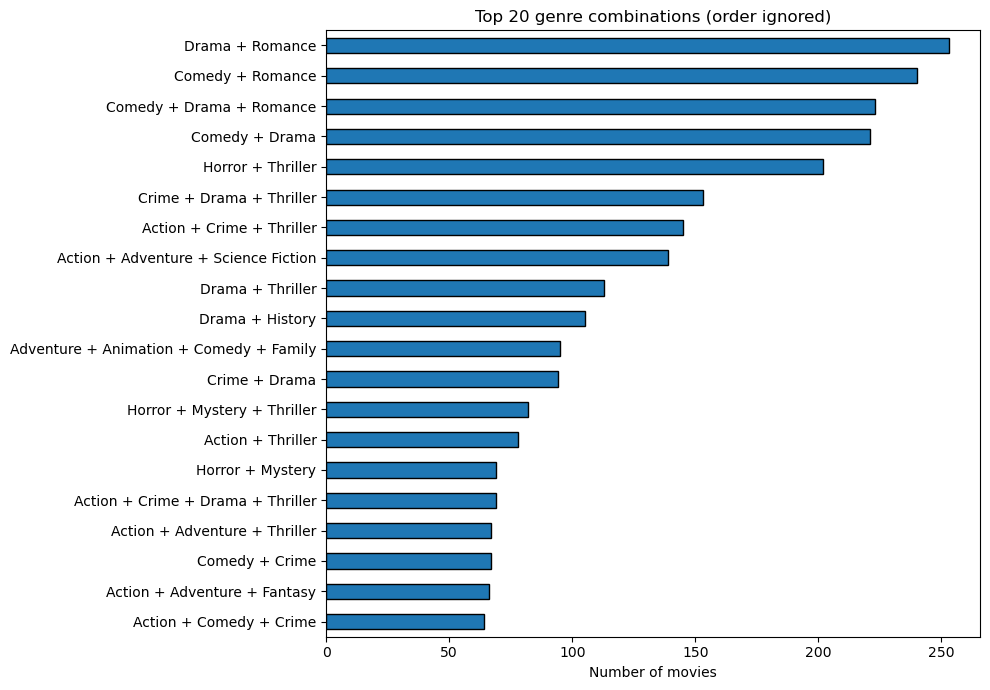

In [72]:
def parse_genres(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, (list, tuple)):
        return [str(x).strip() for x in cell]
    try:
        val = ast.literal_eval(cell)
        if isinstance(val, (list, tuple)):
            return [str(x).strip() for x in val]
    except Exception:
        s = str(cell).strip("[] ")
        items = [x.strip().strip("'\"") for x in s.split(",") if x.strip()]
        return items
    return []


def canonical_combo(genres):
    # remove empties, dedupe, sort so order doesn't matter
    cleaned = [g for g in (g.strip() for g in genres) if g]
    if not cleaned:
        return None
    unique = sorted(set(cleaned))
    return " + ".join(unique)  # human readable key


def plot_genre_combinations(df,
                            top_n=20,
                            min_combo_size=None,
                            max_combo_size=None):

    df["genre_list"] = df["genres"].apply(parse_genres)

    combos = []
    for gl in df["genre_list"]:
        key = canonical_combo(gl)
        if not key:
            continue
        n = len(key.split(" + "))
        if min_combo_size and n < min_combo_size:
            continue
        if max_combo_size and n > max_combo_size:
            continue
        combos.append(key)

    if not combos:
        print("No genre combinations found after filtering.")
        return

    counts = Counter(combos)
    most = counts.most_common(top_n if top_n else None)
    keys, vals = zip(*most)

    # plot
    fig_height = max(4, len(keys) * 0.35)
    plt.figure(figsize=(10, fig_height))
    pd.Series(dict(most)).sort_values().plot(kind="barh", color="tab:blue", edgecolor="k")
    plt.xlabel("Number of movies")
    plt.title(f"Top {len(keys)} genre combinations (order ignored)")
    plt.tight_layout()
    # plt.savefig(out, dpi=150)
    plt.show()

plot_genre_combinations(df_movies,
                        top_n=20,
                        min_combo_size=2,
                        max_combo_size=None)

Documentary     7.389   (79)
War             7.152   (250)
History         7.146   (374)
Animation       7.076   (689)
Western         7.052   (108)
TV Movie        7.005   (55)
Music           7.004   (185)
Drama           6.969   (3243)
Romance         6.786   (1230)
Crime           6.745   (1199)
Family          6.744   (877)
Fantasy         6.739   (909)
Adventure       6.712   (1407)
Mystery         6.624   (721)
Comedy          6.602   (2589)
Action          6.593   (1902)
Science Fiction 6.587   (998)
Thriller        6.565   (2085)
Horror          6.357   (1068)


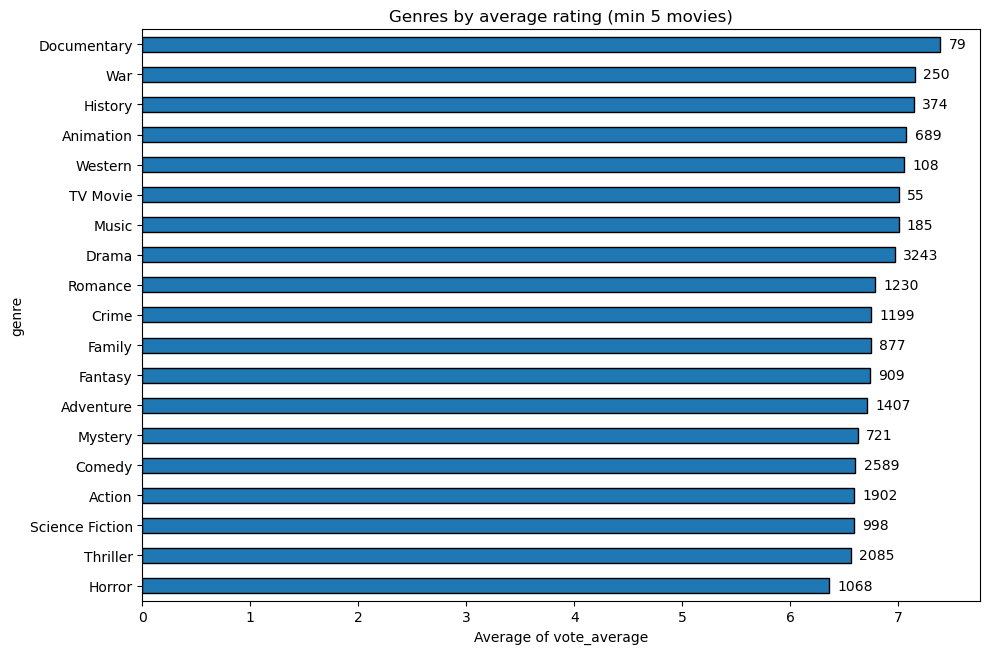

In [74]:
def genres_by_rating(df,
                     min_count: int = 5,
                     top_n: int | None = 50,
                     plot: bool = True):

    if "genres" not in df.columns:
        print("No 'genres' column found.")
        return
    if "rating" not in df.columns:
        print("No 'rating' column found.")
        return

    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df = df.dropna(subset=["rating"])

    df["genre_list"] = df["genres"].apply(parse_genres)
    exploded = df.explode("genre_list").dropna(subset=["genre_list"])
    exploded["genre_list"] = exploded["genre_list"].astype(str).str.strip()

    stats = (
        exploded.groupby("genre_list")["rating"]
        .agg(count="count", mean_vote="mean")
        .reset_index()
        .rename(columns={"genre_list": "genre"})
    )

    stats = stats[stats["count"] >= min_count].sort_values("mean_vote", ascending=False)

    if stats.empty:
        print("No genres meet the minimum count requirement.")
        return

    if top_n:
        stats = stats.head(top_n)

    # print results
    name_width = max(10, int(stats["genre"].str.len().max()))
    for _, row in stats.iterrows():
        print(f"{row['genre']:<{name_width}} {row['mean_vote']:5.3f}   ({int(row['count'])})")

    if plot:
        plt.figure(figsize=(10, max(4, len(stats) * 0.35)))
        stats_sorted = stats.set_index("genre")["mean_vote"].sort_values()
        ax = stats_sorted.plot(kind="barh", color="tab:blue", edgecolor="k")
        ax.set_xlabel("Average of vote_average")
        ax.set_title(f"Genres by average rating (min {min_count} movies)")
        # annotate counts
        counts_map = stats.set_index("genre")["count"].to_dict()
        for i, (val, genre) in enumerate(zip(stats_sorted.values, stats_sorted.index)):
            ax.annotate(f"{int(counts_map[genre])}", xy=(val, i), xytext=(6, 0), textcoords="offset points", va="center")
        plt.tight_layout()
        plt.show()

# default output paths if not provided; ensure CSV is saved and plot shown
genres_by_rating(
    df_movies,
    min_count=5,
    top_n=25,
    plot=True,
    )

Woody Allen            36
Steven Spielberg       35
Clint Eastwood         34
Ridley Scott           28
Steven Soderbergh      24
Alfred Hitchcock       23
Ron Howard             23
Martin Scorsese        21
Robert Zemeckis        20
Tim Burton             20
David Cronenberg       18
John Carpenter         18
Joel Coen              17
Robert Rodriguez       17
Guy Ritchie            17
Roman Polanski         16
Michael Bay            15
Luc Besson             15
Chris Columbus         15
Brian De Palma         15
Wes Anderson           15
Tony Scott             15
Renny Harlin           15
Antoine Fuqua          15
Wes Craven             14


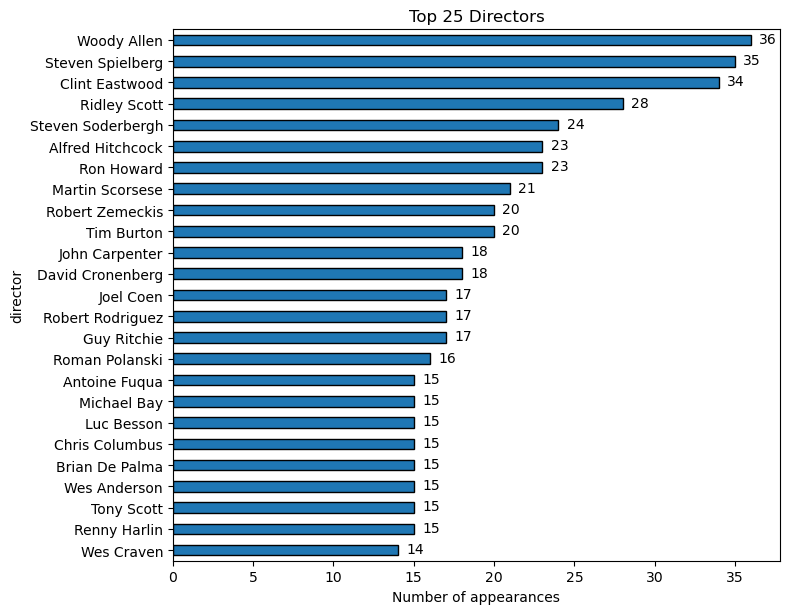

In [75]:
def top_directors(df,
                  top_n: int = 100,
                  plot: bool = True):

    if "director" not in df.columns:
        print("No 'director' column found.")
        return

    # normalize director names, treat NaN/empty as '<unknown>'
    names = df["director"].fillna("<unknown>").astype(str).str.strip()
    names = names.replace({"": "<unknown>"})
    counts = names.value_counts()

    top = counts.head(top_n)

    # print with counts to the right
    name_width = max(20, min(60, max((len(n) for n in top.index), default=20)))
    for name, cnt in top.items():
        print(f"{name:<{name_width}} {cnt:>4}")

    if plot and not top.empty:
        plt.rcParams.update({"figure.autolayout": True})
        fig, ax = plt.subplots(figsize=(8, max(4, len(top) * 0.25)))
        top.sort_values().plot(kind="barh", ax=ax, color="tab:blue", edgecolor="k")
        ax.set_xlabel("Number of appearances")
        ax.set_title(f"Top {len(top)} Directors")
        # annotate counts to the right of each bar
        for i, (val, name) in enumerate(zip(top.sort_values().values, top.sort_values().index)):
            ax.annotate(str(val), xy=(val, i), xytext=(6, -2), textcoords="offset points")
        plt.show()


top_directors(df_movies, top_n=25)

 1. Sergio Leone           8.113   (6)
 2. Charlie Chaplin        8.110   (7)
 3. Akira Kurosawa         8.047   (12)
 4. Hayao Miyazaki         7.943   (12)
 5. Federico Fellini       7.936   (6)
 6. Ingmar Bergman         7.895   (9)
 7. Andrei Tarkovsky       7.870   (7)
 8. Billy Wilder           7.867   (10)
 9. Quentin Tarantino      7.838   (11)
10. Christopher Nolan      7.834   (12)
11. Giuseppe Tornatore     7.829   (5)
12. Pete Docter            7.739   (5)
13. Hirokazu Kore-eda      7.702   (6)
14. Mamoru Hosoda          7.694   (6)
15. James Cameron          7.662   (8)
16. John Ford              7.652   (5)
17. Keishi Otomo           7.640   (5)
18. Luis Buñuel            7.635   (6)
19. Denis Villeneuve       7.634   (9)
20. Isao Takahata          7.630   (5)
21. Makoto Shinkai         7.589   (7)
22. Stanley Kubrick        7.585   (14)
23. Orson Welles           7.558   (5)
24. Michelangelo Antonioni 7.540   (5)
25. François Truffaut      7.528   (5)


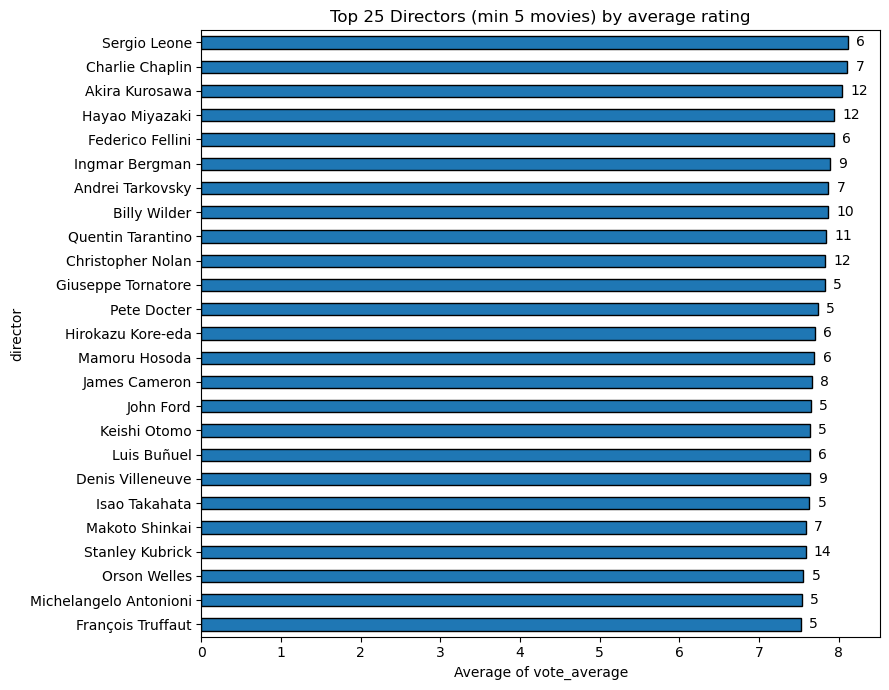

In [78]:
def top_directors_by_rating(df,
                            top_n: int = 25,
                            min_count: int = 5,
                            exclude_unknown: bool = True):

    if "director" not in df.columns:
        print("No 'director' column found.")
        return
    if "rating" not in df.columns:
        print("No 'vote_average' column found.")
        return

    # normalize and drop missing ratings
    df["director"] = df["director"].fillna("<unknown>").astype(str).str.strip()
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df = df.dropna(subset=["rating"])

    if exclude_unknown:
        df = df[df["director"] != "<unknown>"]

    # aggregate: count of movies and mean of vote_average per director
    stats = (
        df.groupby("director", sort=False)["rating"]
        .agg(count="count", mean_vote="mean")
        .reset_index()
    )

    # filter by minimum appearances and sort by mean vote desc
    stats = stats[stats["count"] >= min_count].sort_values("mean_vote", ascending=False)

    top = stats.head(top_n).reset_index(drop=True)

    if top.empty:
        print("No directors meeting the filter criteria.")
        return

    # printing: ranked list, mean rating and appearances to the right
    name_width = max(20, min(60, int(top["director"].str.len().max())))
    for i, row in top.iterrows():
        rank = i + 1
        name = row["director"]
        mean = row["mean_vote"]
        cnt = int(row["count"])
        print(f"{rank:2d}. {name:<{name_width}} {mean:5.3f}   ({cnt})")


    plt.rcParams.update({"figure.autolayout": True})
    fig, ax = plt.subplots(figsize=(9, max(4, len(top) * 0.28)))
    ax = top.set_index("director")["mean_vote"].sort_values().plot(
    kind="barh", color="tab:blue", edgecolor="k", ax=ax
    )
    ax.set_xlabel("Average of vote_average")
    ax.set_title(f"Top {len(top)} Directors (min {min_count} movies) by average rating")
    # annotate count to right of each bar
    means_sorted = top.set_index("director")["mean_vote"].sort_values()
    for i, (director, mean_val) in enumerate(means_sorted.items()):
        cnt = int(top[top["director"] == director]["count"].iloc[0])
        ax.annotate(f"{cnt}", xy=(mean_val, i), xytext=(6, 0), textcoords="offset points", va="center")
    plt.show()


top_directors_by_rating(
    df_movies,
    top_n=25,
    min_count=5
)

### Distribution of Top 10 Production Countries

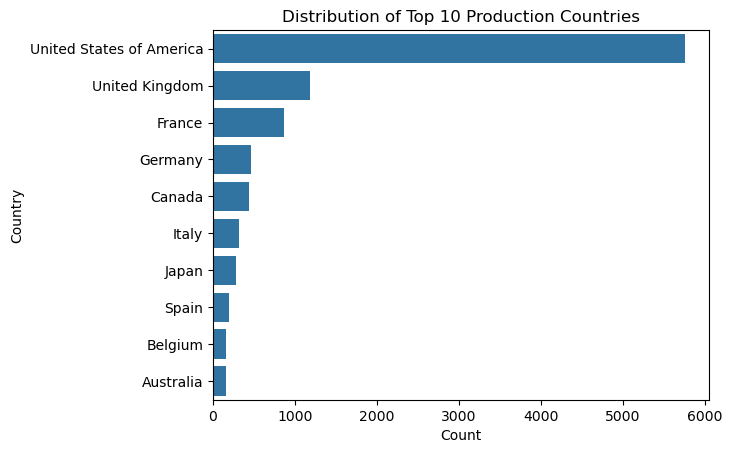

In [20]:
s = df_movies["production_countries"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
pc_counts = s.explode().value_counts()
pc_df = pd.DataFrame(list(pc_counts.items()), columns=["Country", "Count"])
sns.barplot(x="Count", y="Country", data=pc_df.head(10))
plt.title("Distribution of Top 10 Production Countries")
plt.show()

### Top 10 Movie Languages

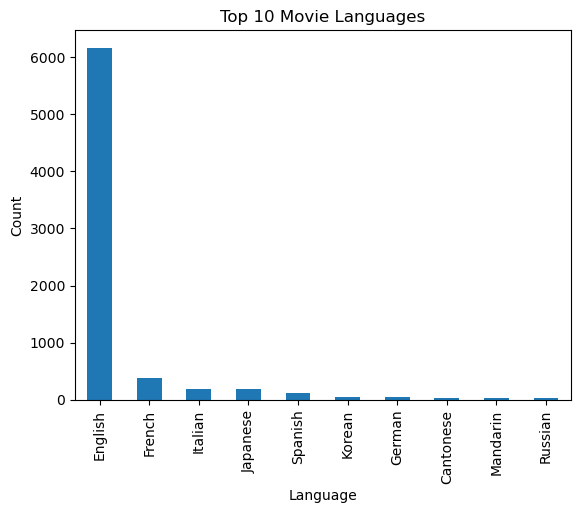

In [21]:
lang_counts = df_movies["original_languages"].value_counts().head(10)
lang_counts.plot(kind='bar')
plt.title("Top 10 Movie Languages")
plt.xlabel("Language")
plt.ylabel("Count")
plt.show()

### Relationship between popularity and vote_count

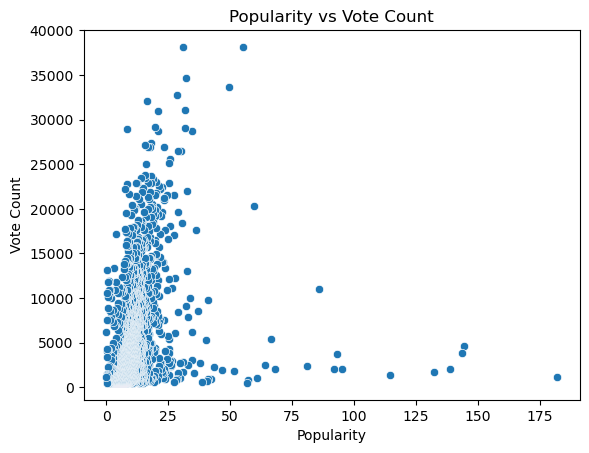

In [22]:
sns.scatterplot(data=df_movies, x="popularity", y="vote_count", alpha=1)
plt.title("Popularity vs Vote Count")
plt.xlabel("Popularity")
plt.ylabel("Vote Count")
plt.show()

### Relationship between popularity and rating

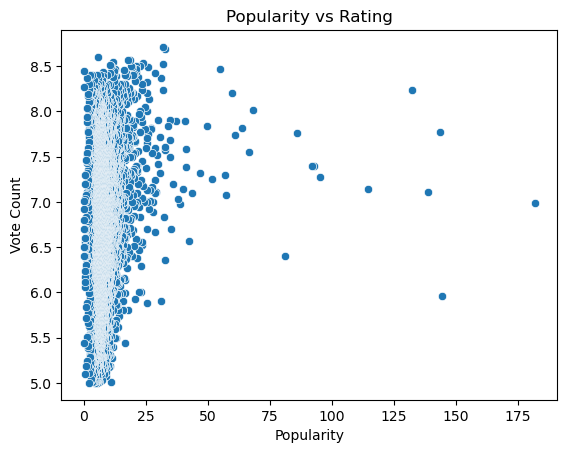

In [23]:
sns.scatterplot(data=df_movies, x="popularity", y="rating", alpha=1)
plt.title("Popularity vs Rating")
plt.xlabel("Popularity")
plt.ylabel("Vote Count")
plt.show()

### Relationship between vote_count and rating

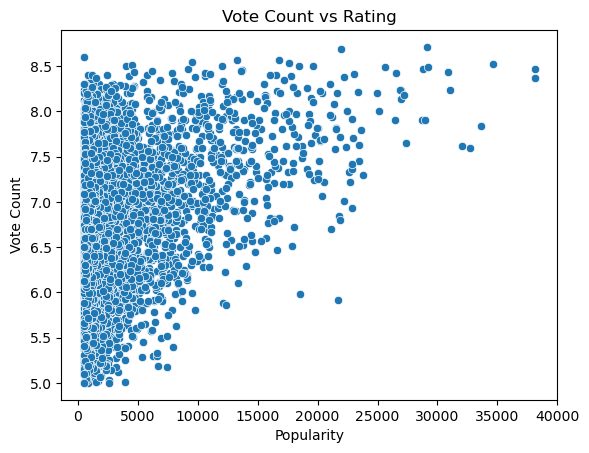

In [24]:
sns.scatterplot(data=df_movies, x="vote_count", y="rating", alpha=1)
plt.title("Vote Count vs Rating")
plt.xlabel("Popularity")
plt.ylabel("Vote Count")
plt.show()

### Correlation heatmap (numerical features)

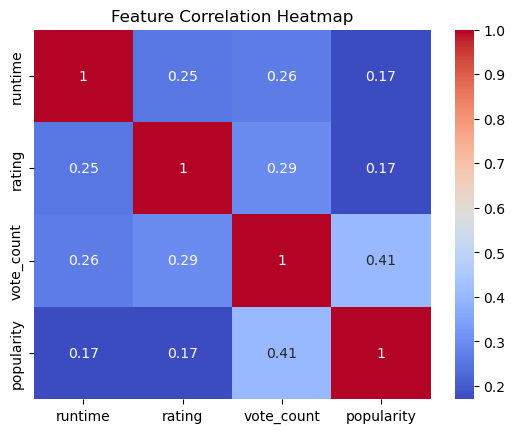

In [25]:
numeric_cols = ["runtime", "rating", "vote_count", "popularity"]
sns.heatmap(df_movies[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


### Relationship between genre and popularity

In [26]:
df_movies["genres"] = df_movies["genres"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_genre_exploded = df_movies.explode('genres')
df_genre_exploded

,id,imdb_id,title,original_title,genres,overview,tagline,release_year,release_month,release_date,runtime,rating,vote_count,popularity,adult,original_languages,production_countries,release_decade
0,1038392,tt22898462,The Conjuring: Last Rites,The Conjuring: Last Rites,Horror,Paranormal investigators Ed and Lorraine Warre...,The case that ended it all.,2025,9,3,135,6.990,1152,181.8772,False,English,['United States of America'],2020
1,7451,tt0295701,xXx,xXx,Action,Xander Cage is your standard adrenaline junkie...,A new breed of secret agent.,2002,8,9,124,5.965,4605,144.5066,False,English,['United States of America'],2000
1,7451,tt0295701,xXx,xXx,Adventure,Xander Cage is your standard adrenaline junkie...,A new breed of secret agent.,2002,8,9,124,5.965,4605,144.5066,False,English,['United States of America'],2000
1,7451,tt0295701,xXx,xXx,Thriller,Xander Cage is your standard adrenaline junkie...,A new breed of secret agent.,2002,8,9,124,5.965,4605,144.5066,False,English,['United States of America'],2000
1,7451,tt0295701,xXx,xXx,Crime,Xander Cage is your standard adrenaline junkie...,A new breed of secret agent.,2002,8,9,124,5.965,4605,144.5066,False,English,['United States of America'],2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391,12477,tt0095327,Grave of the Fireflies,火垂るの墓,Drama,"In the final months of World War II, 14-year-o...",Why do fireflies have to die so soon?,1988,4,16,89,8.447,6163,0.0107,False,Japanese,['Japan'],1980
7391,12477,tt0095327,Grave of the Fireflies,火垂るの墓,War,"In the final months of World War II, 14-year-o...",Why do fireflies have to die so soon?,1988,4,16,89,8.447,6163,0.0107,False,Japanese,['Japan'],1980
7392,92321,tt2061702,Hotarubi no Mori e,蛍火の杜へ,Romance,One hot summer day a little girl gets lost in ...,NaN,2011,9,17,45,8.271,1172,0.0068,False,Japanese,['Japan'],2010
7392,92321,tt2061702,Hotarubi no Mori e,蛍火の杜へ,Animation,One hot summer day a little girl gets lost in ...,NaN,2011,9,17,45,8.271,1172,0.0068,False,Japanese,['Japan'],2010


### Word cloud of overviews

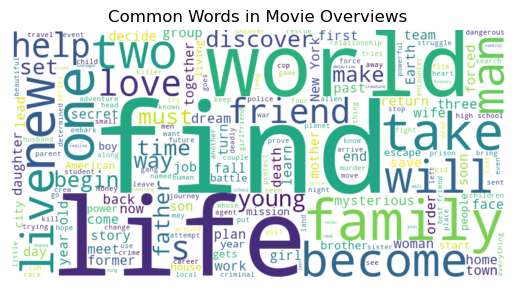

In [27]:
from wordcloud import WordCloud

text = " ".join(df_movies["overview"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in Movie Overviews")
plt.show()


### Multi-feature visualization

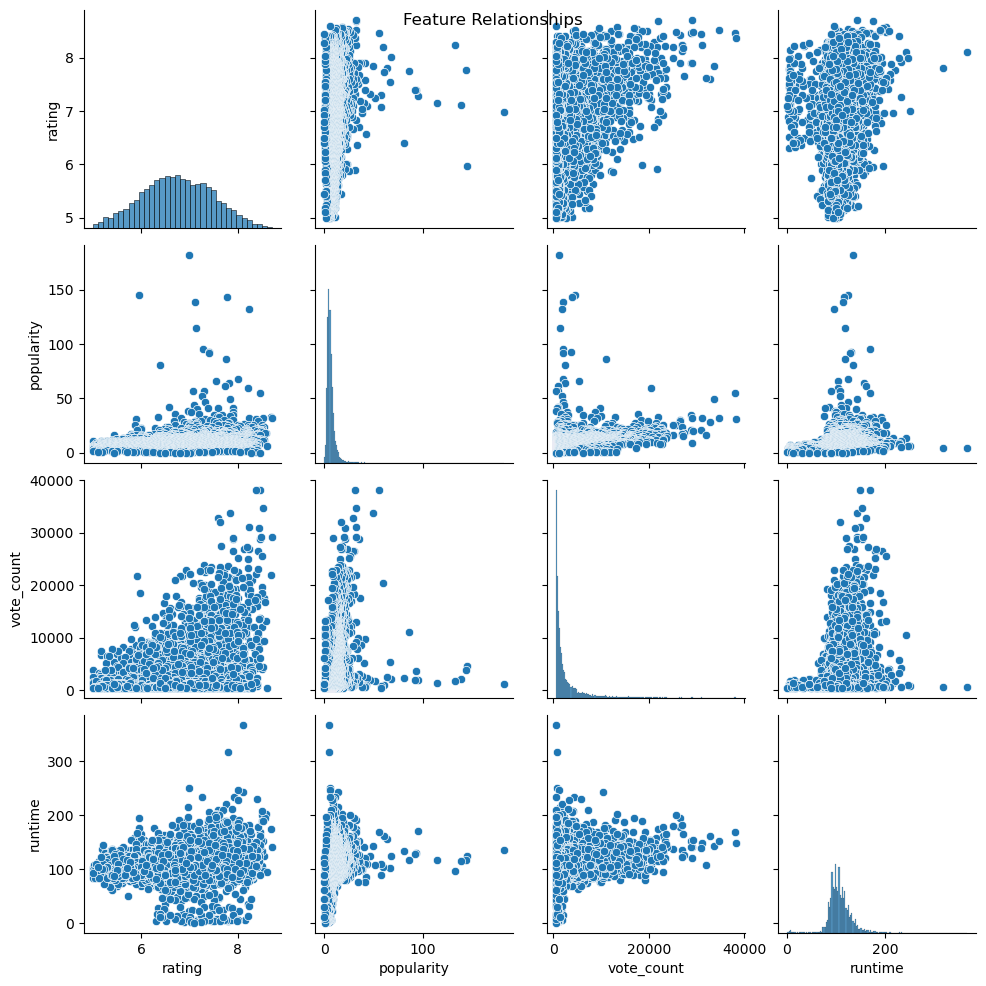

In [28]:
sns.pairplot(df_movies[["rating", "popularity", "vote_count", "runtime"]])
plt.suptitle("Feature Relationships")
plt.show()

## Visualize review dataset features

In [37]:
review_counts = df_reviews['username'].value_counts()
user_movie_count = df_reviews.groupby('username')['movie_id'].nunique()


In [ ]:
review_counts
avg_movies_per_user = user_movie_count.mean()
print(f"Average number of movies reviewed per user: {avg_movies_per_user:.2f}")


Average number of movies reviewed per user: 11.87


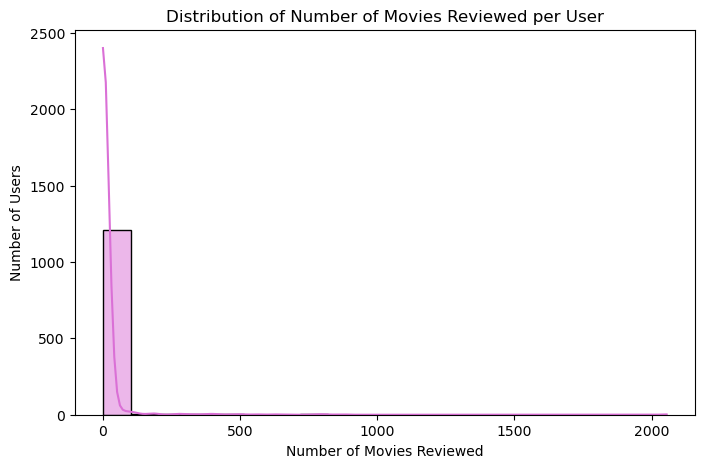

In [41]:
plt.figure(figsize=(8,5))
sns.histplot(user_movie_count, bins=20, kde=True, color='orchid')
plt.title("Distribution of Number of Movies Reviewed per User")
plt.xlabel("Number of Movies Reviewed")
plt.ylabel("Number of Users")
plt.show()

A few users contribute most of the reviews, while the majority contribute only a few

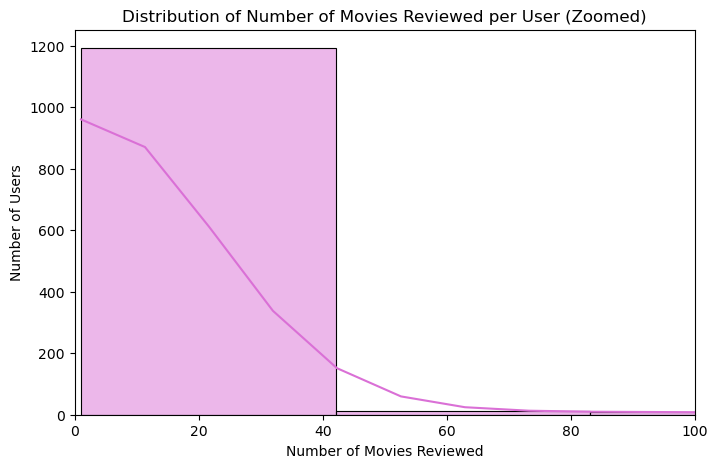

In [42]:
plt.figure(figsize=(8,5))
sns.histplot(user_movie_count, bins=50, kde=True, color='orchid')
plt.xlim(0, 100)  # Focus on first 100 movies reviewed
plt.title("Distribution of Number of Movies Reviewed per User (Zoomed)")
plt.xlabel("Number of Movies Reviewed")
plt.ylabel("Number of Users")
plt.show()

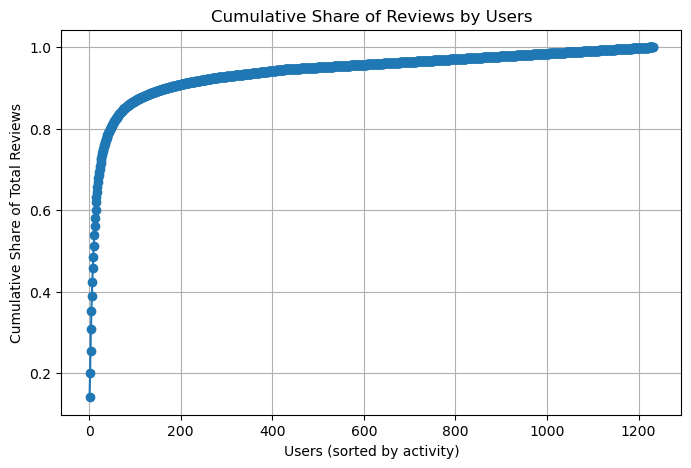

In [32]:
import numpy as np

sorted_counts = np.sort(review_counts.values)[::-1]
cumulative = np.cumsum(sorted_counts) / np.sum(sorted_counts)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(sorted_counts)+1), cumulative, marker='o')
plt.title("Cumulative Share of Reviews by Users")
plt.xlabel("Users (sorted by activity)")
plt.ylabel("Cumulative Share of Total Reviews")
plt.grid(True)
plt.show()


### Create One-hot encoded columns for genres

In [147]:
df_movies["genres"] = df_movies["genres"].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df_movies["genres"])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df_movies.index)
df = pd.concat([df_movies, genres_df], axis=1)

# df = df.drop(columns=["genres"]) #  Drop the old text column

df.head(3)

,id,imdb_id,title,original_title,genres,overview,tagline,release_year,release_month,release_date,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1038392,tt22898462,The Conjuring: Last Rites,The Conjuring: Last Rites,[Horror],Paranormal investigators Ed and Lorraine Warre...,The case that ended it all.,2025,9,3,...,0,1,0,0,0,0,0,0,0,0
1,7451,tt0295701,xXx,xXx,"[Action, Adventure, Thriller, Crime]",Xander Cage is your standard adrenaline junkie...,A new breed of secret agent.,2002,8,9,...,0,0,0,0,0,0,0,1,0,0
2,1010581,tt21909764,My Fault,Culpa mía,"[Drama, Romance, Thriller]","Noah must leave her city, boyfriend, and frien...",Love can only survive in the shadow of secrets.,2023,6,8,...,0,0,0,0,1,0,0,1,0,0
